# Creating climatologies with interannual variability between months for nutrients, NPP, zooplankton biomass, temperature, sea-ice, and light fields, as well as chlorophyll! 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

## Phytoplankton Biomass

In [5]:
phytoC = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/phytoC_interannual.npy")

In [6]:
# Depth integrated top 50 m 
phytoC_50m = np.nansum(phytoC[:,:,:,0:5,:,:], axis =(0,3))*10/50 

# Surface Chl. 
phytoC_surface = np.nansum(phytoC[:,:,:,0,:,:], axis =0) 

# Model Chlorophyll for every region (surface)
phyto_ao = np.nanmean(phytoC_surface[:,:,170:180,:], axis=(2,3))
phyto_cs = np.nanmean(phytoC_surface[:,:,149:170,0:25], axis = (2,3))
phyto_bs = np.nanmean(phytoC_surface[:,:,149:170,25:55], axis = (2,3))
phyto_ca = np.nanmean(phytoC_surface[:,:,149:170,55:110], axis = (2,3))
phyto_bb = np.nanmean(phytoC_surface[:,:,149:170,110:135], axis = (2,3))
phyto_ess = np.nanmean(phytoC_surface[:,:,149:170,325:360], axis = (2,3))
phyto_ls = np.nanmean(phytoC_surface[:,:,149:170,270:325], axis = (2,3))
phyto_ns = np.nanmean(phytoC_surface[:,:,149:170,155:205], axis = (2,3))
phyto_bts =np.nanmean(phytoC_surface[:,:,149:170,205:233], axis = (2,3))
phyto_ks = np.nanmean(phytoC_surface[:,:,149:170,233:270], axis = (2,3))

# Top 50 meters
phyto_ao_50m = np.nanmean(phytoC_50m[:,:,170:180,:], axis=(2,3))
phyto_cs_50m = np.nanmean(phytoC_50m[:,:,149:170,0:25], axis = (2,3))
phyto_bs_50m = np.nanmean(phytoC_50m[:,:,149:170,25:55], axis = (2,3))
phyto_ca_50m = np.nanmean(phytoC_50m[:,:,149:170,55:110], axis = (2,3))
phyto_bb_50m = np.nanmean(phytoC_50m[:,:,149:170,110:135], axis = (2,3))
phyto_ess_50m = np.nanmean(phytoC_50m[:,:,149:170,325:360], axis = (2,3))
phyto_ls_50m = np.nanmean(phytoC_50m[:,:,149:170,270:325], axis = (2,3))
phyto_ns_50m = np.nanmean(phytoC_50m[:,:,149:170,155:205], axis = (2,3))
phyto_bts_50m =np.nanmean(phytoC_50m[:,:,149:170,205:233], axis = (2,3))
phyto_ks_50m = np.nanmean(phytoC_50m[:,:,149:170,233:270], axis = (2,3))

## Chlorophyll

In [7]:
phytoChl = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/phytoChl_interannual.npy")

In [8]:
# Depth integrated top 50 m 
phytoChl_50m = np.nansum(phytoChl[:,:,:,0:5,:,:], axis =(0,3))*10/50 

# Surface Chl. 
phytoChl_surface = np.nansum(phytoChl[:,:,:,0,:,:], axis =0) 

# Model Chlorophyll for every region (surface)
chl_ao = np.nanmean(phytoChl_surface[:,:,170:180,:], axis=(2,3))
chl_cs = np.nanmean(phytoChl_surface[:,:,149:170,0:25], axis = (2,3))
chl_bs = np.nanmean(phytoChl_surface[:,:,149:170,25:55], axis = (2,3))
chl_ca = np.nanmean(phytoChl_surface[:,:,149:170,55:110], axis = (2,3))
chl_bb = np.nanmean(phytoChl_surface[:,:,149:170,110:135], axis = (2,3))
chl_ess = np.nanmean(phytoChl_surface[:,:,149:170,325:360], axis = (2,3))
chl_ls = np.nanmean(phytoChl_surface[:,:,149:170,270:325], axis = (2,3))
chl_ns = np.nanmean(phytoChl_surface[:,:,149:170,155:205], axis = (2,3))
chl_bts =np.nanmean(phytoChl_surface[:,:,149:170,205:233], axis = (2,3))
chl_ks = np.nanmean(phytoChl_surface[:,:,149:170,233:270], axis = (2,3))

# Top 50 meters
chl_ao_50m = np.nanmean(phytoChl_50m[:,:,170:180,:], axis=(2,3))
chl_cs_50m = np.nanmean(phytoChl_50m[:,:,149:170,0:25], axis = (2,3))
chl_bs_50m = np.nanmean(phytoChl_50m[:,:,149:170,25:55], axis = (2,3))
chl_ca_50m = np.nanmean(phytoChl_50m[:,:,149:170,55:110], axis = (2,3))
chl_bb_50m = np.nanmean(phytoChl_50m[:,:,149:170,110:135], axis = (2,3))
chl_ess_50m = np.nanmean(phytoChl_50m[:,:,149:170,325:360], axis = (2,3))
chl_ls_50m = np.nanmean(phytoChl_50m[:,:,149:170,270:325], axis = (2,3))
chl_ns_50m = np.nanmean(phytoChl_50m[:,:,149:170,155:205], axis = (2,3))
chl_bts_50m =np.nanmean(phytoChl_50m[:,:,149:170,205:233], axis = (2,3))
chl_ks_50m = np.nanmean(phytoChl_50m[:,:,149:170,233:270], axis = (2,3))

### Temperature 

In [9]:
temp_ds_inter = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/temp_interannual.npy")

In [10]:
temp_ds_inter.shape

(20, 12, 60, 180, 360)

In [11]:
temp_ao = np.nanmean(temp_ds_inter[:,:,0,170:180,:], axis=(2,3))
temp_cs = np.nanmean(temp_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
temp_bs = np.nanmean(temp_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
temp_ca = np.nanmean(temp_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
temp_bb = np.nanmean(temp_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
temp_ess = np.nanmean(temp_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
temp_ls = np.nanmean(temp_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
temp_ns = np.nanmean(temp_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
temp_bts =np.nanmean(temp_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
temp_ks = np.nanmean(temp_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

### Zooplankton biomass

In [12]:
zooC = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/zooC_interannual.npy")

In [13]:
# Depth integrated top 50 m 
zooC_50m = np.nansum(zooC[:,:,:,0:5,:,:], axis =(0,3))*10/50 

# Surface Chl. 
zooC_surface = np.nansum(zooC[:,:,:,0,:,:], axis =0) 

# Model Chlorophyll for every region (surface)
zooC_ao = np.nanmean(zooC_surface[:,:,170:180,:], axis=(2,3))
zooC_cs = np.nanmean(zooC_surface[:,:,149:170,0:25], axis = (2,3))
zooC_bs = np.nanmean(zooC_surface[:,:,149:170,25:55], axis = (2,3))
zooC_ca = np.nanmean(zooC_surface[:,:,149:170,55:110], axis = (2,3))
zooC_bb = np.nanmean(zooC_surface[:,:,149:170,110:135], axis = (2,3))
zooC_ess = np.nanmean(zooC_surface[:,:,149:170,325:360], axis = (2,3))
zooC_ls = np.nanmean(zooC_surface[:,:,149:170,270:325], axis = (2,3))
zooC_ns = np.nanmean(zooC_surface[:,:,149:170,155:205], axis = (2,3))
zooC_bts =np.nanmean(zooC_surface[:,:,149:170,205:233], axis = (2,3))
zooC_ks = np.nanmean(zooC_surface[:,:,149:170,233:270], axis = (2,3))

# Top 50 meters
zooC_ao_50m = np.nanmean(zooC_50m[:,:,170:180,:], axis=(2,3))
zooC_cs_50m = np.nanmean(zooC_50m[:,:,149:170,0:25], axis = (2,3))
zooC_bs_50m = np.nanmean(zooC_50m[:,:,149:170,25:55], axis = (2,3))
zooC_ca_50m = np.nanmean(zooC_50m[:,:,149:170,55:110], axis = (2,3))
zooC_bb_50m = np.nanmean(zooC_50m[:,:,149:170,110:135], axis = (2,3))
zooC_ess_50m = np.nanmean(zooC_50m[:,:,149:170,325:360], axis = (2,3))
zooC_ls_50m = np.nanmean(zooC_50m[:,:,149:170,270:325], axis = (2,3))
zooC_ns_50m = np.nanmean(zooC_50m[:,:,149:170,155:205], axis = (2,3))
zooC_bts_50m =np.nanmean(zooC_50m[:,:,149:170,205:233], axis = (2,3))
zooC_ks_50m = np.nanmean(zooC_50m[:,:,149:170,233:270], axis = (2,3))

### photoC_total

In [14]:
photoC_TOT_ds_inter = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/photoC_TOT_interannual.npy")

In [15]:
photoC_TOT_ds_inter.shape

(20, 12, 15, 180, 360)

In [16]:
photoC_TOT_ao = np.nanmean(photoC_TOT_ds_inter[:,:,0,170:180,:], axis=(2,3))
photoC_TOT_cs = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
photoC_TOT_bs = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
photoC_TOT_ca = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
photoC_TOT_bb = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
photoC_TOT_ess = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
photoC_TOT_ls = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
photoC_TOT_ns = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
photoC_TOT_bts =np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
photoC_TOT_ks = np.nanmean(photoC_TOT_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

### Sea-ICE

In [17]:
ECOSYS_IFRAC_ds_inter = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/ECOSYS_IFRAC_interannual.npy")

In [18]:
ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,170:180,:], axis=(2,3))
ECOSYS_IFRAC_cs = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,0:25], axis = (2,3))
ECOSYS_IFRAC_bs = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,25:55], axis = (2,3))
ECOSYS_IFRAC_ca = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,55:110], axis = (2,3))
ECOSYS_IFRAC_bb = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,110:135], axis = (2,3))
ECOSYS_IFRAC_ess = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,325:360], axis = (2,3))
ECOSYS_IFRAC_ls = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,270:325], axis = (2,3))
ECOSYS_IFRAC_ns = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,155:205], axis = (2,3))
ECOSYS_IFRAC_bts =np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,205:233], axis = (2,3))
ECOSYS_IFRAC_ks = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:170,233:270], axis = (2,3))

### PAR average 

In [19]:
PAR_avg_ds_inter = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/PAR_avg_interannual.npy")

In [20]:
PAR_avg_ao = np.nanmean(PAR_avg_ds_inter[:,:,0,170:180,:], axis=(2,3))
PAR_avg_cs = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
PAR_avg_bs = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
PAR_avg_ca = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
PAR_avg_bb = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
PAR_avg_ess = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
PAR_avg_ls = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
PAR_avg_ns = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
PAR_avg_bts =np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
PAR_avg_ks = np.nanmean(PAR_avg_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

### NO3

In [21]:
NO3_ds_inter = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1990_2009/Interannual_np_files/NO3_interannual.npy")


In [22]:
NO3_ao = np.nanmean(NO3_ds_inter[:,:,0,170:180,:], axis=(2,3))
NO3_cs = np.nanmean(NO3_ds_inter[:,:,0,149:170,0:25], axis = (2,3))
NO3_bs = np.nanmean(NO3_ds_inter[:,:,0,149:170,25:55], axis = (2,3))
NO3_ca = np.nanmean(NO3_ds_inter[:,:,0,149:170,55:110], axis = (2,3))
NO3_bb = np.nanmean(NO3_ds_inter[:,:,0,149:170,110:135], axis = (2,3))
NO3_ess = np.nanmean(NO3_ds_inter[:,:,0,149:170,325:360], axis = (2,3))
NO3_ls = np.nanmean(NO3_ds_inter[:,:,0,149:170,270:325], axis = (2,3))
NO3_ns = np.nanmean(NO3_ds_inter[:,:,0,149:170,155:205], axis = (2,3))
NO3_bts =np.nanmean(NO3_ds_inter[:,:,0,149:170,205:233], axis = (2,3))
NO3_ks = np.nanmean(NO3_ds_inter[:,:,0,149:170,233:270], axis = (2,3))

In [23]:
NO3_ao.shape

(20, 12)

## CREATE Climatologies with variability shading! 

In [7]:
# This is the error on the observations
err_ao = np.nanstd(phyto_ao,axis=0)
err_cs = np.nanstd(phyto_cs,axis=0)
err_bs = np.nanstd(phyto_bs,axis=0)
err_ca = np.nanstd(phyto_ca,axis=0)
err_bb = np.nanstd(phyto_bb,axis=0)
err_ess = np.nanstd(phyto_ess,axis=0)
err_ls = np.nanstd(phyto_ls,axis=0)
err_ns = np.nanstd(phyto_ns,axis=0)
err_bts = np.nanstd(phyto_bts,axis=0)
err_ks = np.nanstd(phyto_ks,axis=0)

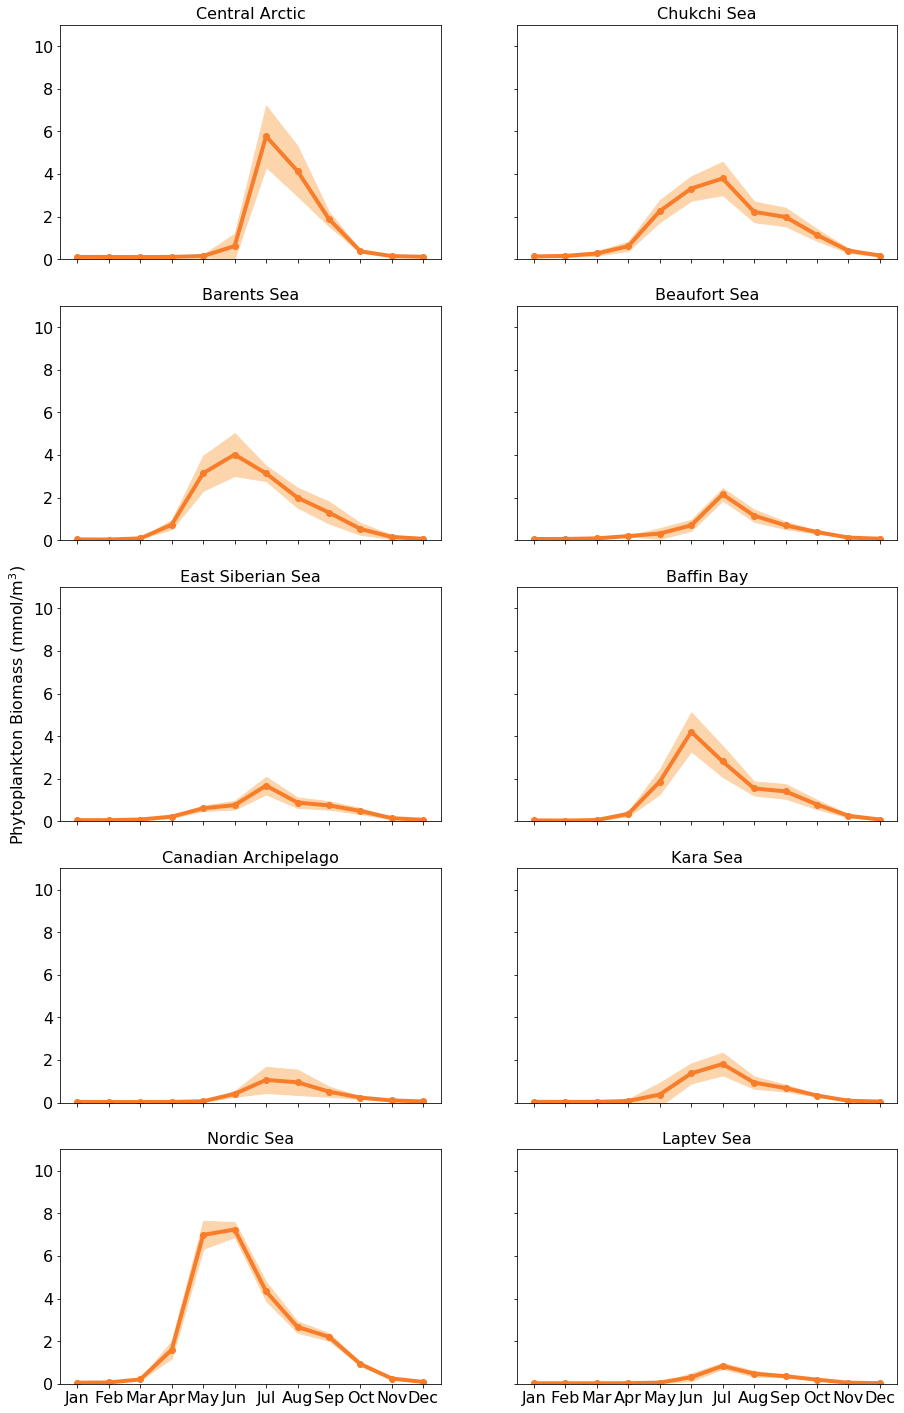

In [8]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(phyto_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(phyto_ao,axis=0)-err_ao,np.nanmean(phyto_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(0,11);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(phyto_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(phyto_bts,axis=0)-err_bts,np.nanmean(phyto_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(0,11);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(phyto_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(phyto_cs,axis=0)-err_cs,np.nanmean(phyto_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,11);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(phyto_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(phyto_ess,axis=0)-err_ess,np.nanmean(phyto_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Phytoplankton Biomass (mmol/m$^3$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(0,11);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(phyto_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(phyto_ca,axis=0)-err_ca,np.nanmean(phyto_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(0,11); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(phyto_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(phyto_ns,axis=0)-err_ns,np.nanmean(phyto_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(0,11);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(phyto_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(phyto_bs,axis=0)-err_bs,np.nanmean(phyto_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,11);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(phyto_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(phyto_bb,axis=0)-err_bb,np.nanmean(phyto_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,11);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(phyto_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(phyto_ks,axis=0)-err_ks,np.nanmean(phyto_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,11);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(phyto_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(phyto_ls,axis=0)-err_ls,np.nanmean(phyto_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,11);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phytoC_interannual_climatology',dpi=600, bbox_inches='tight')

In [38]:
# This is the error on the observations
err_ao = np.nanstd(NO3_ao,axis=0)
err_cs = np.nanstd(NO3_cs,axis=0)
err_bs = np.nanstd(NO3_bs,axis=0)
err_ca = np.nanstd(NO3_ca,axis=0)
err_bb = np.nanstd(NO3_bb,axis=0)
err_ess = np.nanstd(NO3_ess,axis=0)
err_ls = np.nanstd(NO3_ls,axis=0)
err_ns = np.nanstd(NO3_ns,axis=0)
err_bts = np.nanstd(NO3_bts,axis=0)
err_ks = np.nanstd(NO3_ks,axis=0)

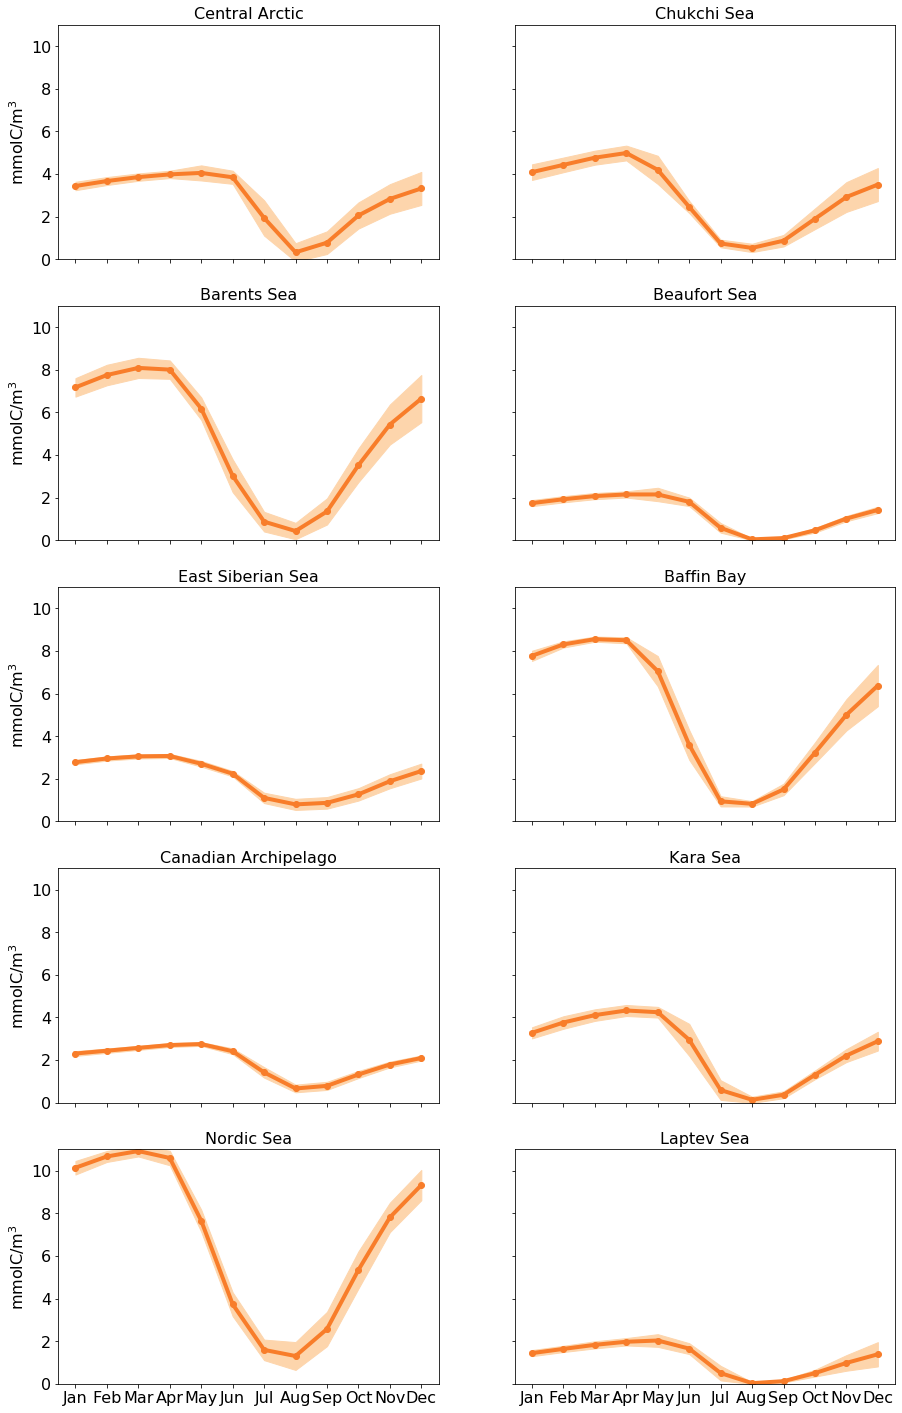

In [39]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(NO3_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(NO3_ao,axis=0)-err_ao,np.nanmean(NO3_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_ylabel('$mmol C$/$m^3$', fontsize=16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(0,11);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(NO3_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(NO3_bts,axis=0)-err_bts,np.nanmean(NO3_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_ylabel('$mmol C$/$m^3$', fontsize=16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(0,11);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(NO3_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(NO3_cs,axis=0)-err_cs,np.nanmean(NO3_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,11);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(NO3_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(NO3_ess,axis=0)-err_ess,np.nanmean(NO3_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('$mmol C$/$m^3$', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(0,11);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(NO3_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(NO3_ca,axis=0)-err_ca,np.nanmean(NO3_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_ylabel('$mmol C$/$m^3$', fontsize=16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(0,11); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(NO3_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(NO3_ns,axis=0)-err_ns,np.nanmean(NO3_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_ylabel('$mmol C$/$m^3$', fontsize=16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(0,11);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(NO3_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(NO3_bs,axis=0)-err_bs,np.nanmean(NO3_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,11);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(NO3_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(NO3_bb,axis=0)-err_bb,np.nanmean(NO3_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,11);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(NO3_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(NO3_ks,axis=0)-err_ks,np.nanmean(NO3_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,11);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(NO3_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(NO3_ls,axis=0)-err_ls,np.nanmean(NO3_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,11);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/NO3_interannual_climatology',dpi=600, bbox_inches='tight')


In [40]:
# This is the error on the observations
err_ao = np.nanstd(PAR_avg_ao,axis=0)
err_cs = np.nanstd(PAR_avg_cs,axis=0)
err_bs = np.nanstd(PAR_avg_bs,axis=0)
err_ca = np.nanstd(PAR_avg_ca,axis=0)
err_bb = np.nanstd(PAR_avg_bb,axis=0)
err_ess = np.nanstd(PAR_avg_ess,axis=0)
err_ls = np.nanstd(PAR_avg_ls,axis=0)
err_ns = np.nanstd(PAR_avg_ns,axis=0)
err_bts = np.nanstd(PAR_avg_bts,axis=0)
err_ks = np.nanstd(PAR_avg_ks,axis=0)

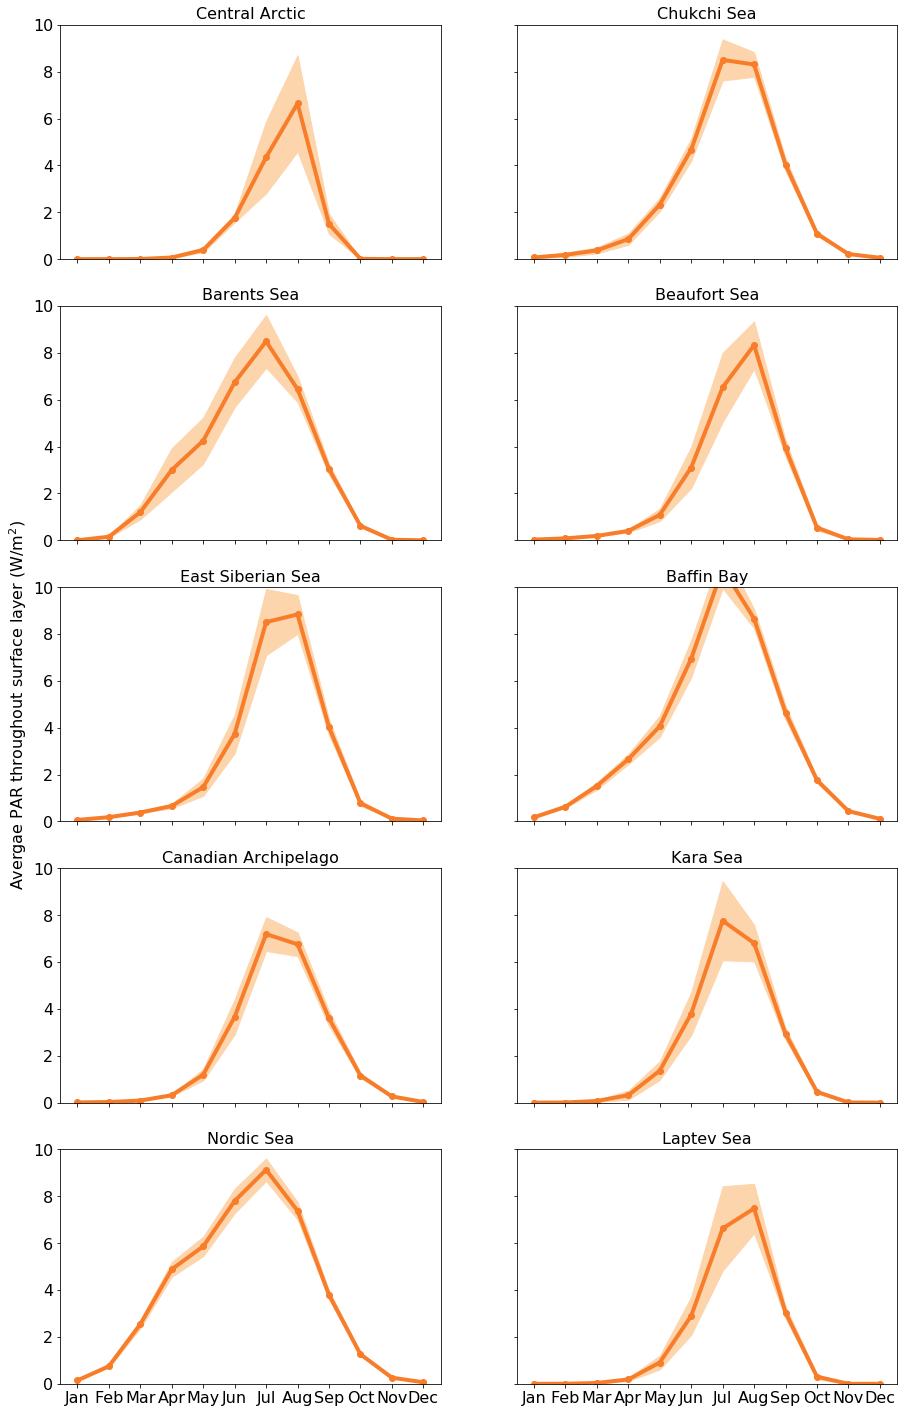

In [41]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(PAR_avg_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(PAR_avg_ao,axis=0)-err_ao,np.nanmean(PAR_avg_ao,axis=0)+err_ao, color=cmap(2))
#ax1.set_ylabel('Avergae PAR throughout surface layer (W/m$^2$)', fontsize=16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax1.set_ylim(0,50);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(PAR_avg_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(PAR_avg_bts,axis=0)-err_bts,np.nanmean(PAR_avg_bts,axis=0)+err_bts, color=cmap(2))
#ax2.set_ylabel('Avergae PAR throughout surface layer (W/m$^2$)', fontsize=16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax2.set_ylim(0,50);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(PAR_avg_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(PAR_avg_cs,axis=0)-err_cs,np.nanmean(PAR_avg_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,50);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(PAR_avg_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(PAR_avg_ess,axis=0)-err_ess,np.nanmean(PAR_avg_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Avergae PAR throughout surface layer (W/m$^2$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax4.set_ylim(0,50);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(PAR_avg_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(PAR_avg_ca,axis=0)-err_ca,np.nanmean(PAR_avg_ca,axis=0)+err_ca, color=cmap(2))
#ax5.set_ylabel('Avergae PAR throughout surface layer (W/m$^2$)', fontsize=16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax5.set_ylim(0,50); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(PAR_avg_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(PAR_avg_ns,axis=0)-err_ns,np.nanmean(PAR_avg_ns,axis=0)+err_ns, color=cmap(2))
#ax6.set_ylabel('Avergae PAR throughout surface layer (W/m$^2$)', fontsize=16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(0,50);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(PAR_avg_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(PAR_avg_bs,axis=0)-err_bs,np.nanmean(PAR_avg_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,50);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(PAR_avg_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(PAR_avg_bb,axis=0)-err_bb,np.nanmean(PAR_avg_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,50);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(PAR_avg_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(PAR_avg_ks,axis=0)-err_ks,np.nanmean(PAR_avg_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,50);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(PAR_avg_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(PAR_avg_ls,axis=0)-err_ls,np.nanmean(PAR_avg_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,50);  ax.set_yticklabels(''); 
#cbar.set_label('Avergae PAR throughout surface layer (W/m$^2$)', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/PAR_avg_interannual_climatology',dpi=600, bbox_inches='tight')

In [42]:
# This is the error on the observations
err_ao = np.nanstd(photoC_TOT_ao,axis=0)
err_cs = np.nanstd(photoC_TOT_cs,axis=0)
err_bs = np.nanstd(photoC_TOT_bs,axis=0)
err_ca = np.nanstd(photoC_TOT_ca,axis=0)
err_bb = np.nanstd(photoC_TOT_bb,axis=0)
err_ess = np.nanstd(photoC_TOT_ess,axis=0)
err_ls = np.nanstd(photoC_TOT_ls,axis=0)
err_ns = np.nanstd(photoC_TOT_ns,axis=0)
err_bts = np.nanstd(photoC_TOT_bts,axis=0)
err_ks = np.nanstd(photoC_TOT_ks,axis=0)

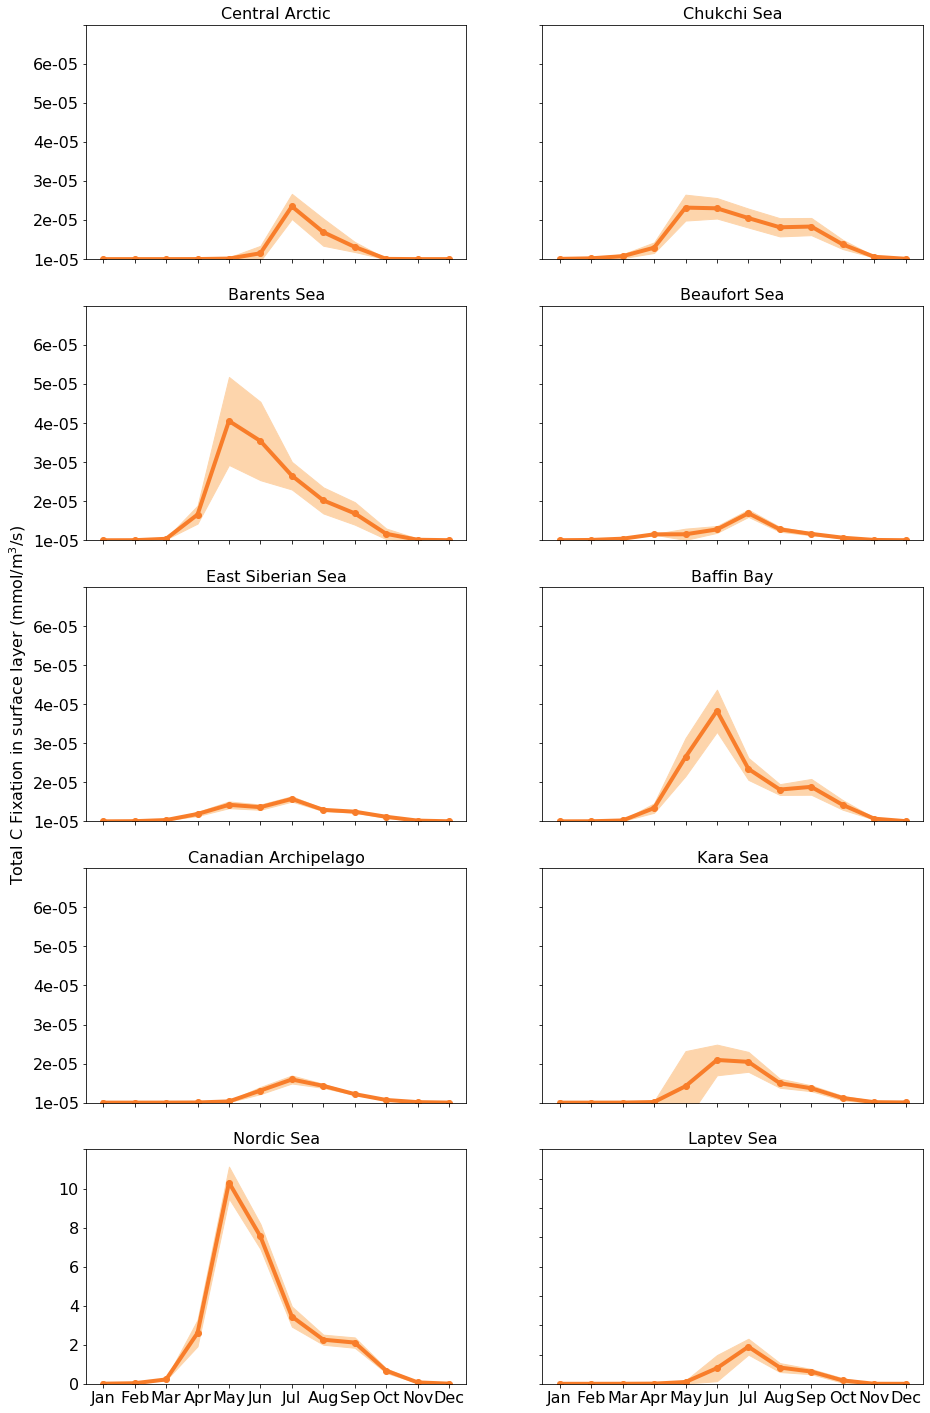

In [43]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(photoC_TOT_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(photoC_TOT_ao,axis=0)-err_ao,np.nanmean(photoC_TOT_ao,axis=0)+err_ao, color=cmap(2))
#ax1.set_ylabel('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize=16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0.00001,0.00002,0.00003,0.00004,0.00005,0.00006],fontsize=16)
ax1.set_ylim(0,0.00006);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(photoC_TOT_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(photoC_TOT_bts,axis=0)-err_bts,np.nanmean(photoC_TOT_bts,axis=0)+err_bts, color=cmap(2))
#ax2.set_ylabel('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize=16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0.00001,0.00002,0.00003,0.00004,0.00005,0.00006],fontsize=16)
ax2.set_ylim(0,0.00006);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(photoC_TOT_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(photoC_TOT_cs,axis=0)-err_cs,np.nanmean(photoC_TOT_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,0.00006);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(photoC_TOT_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(photoC_TOT_ess,axis=0)-err_ess,np.nanmean(photoC_TOT_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0.00001,0.00002,0.00003,0.00004,0.00005,0.00006],fontsize=16)
ax4.set_ylim(0,0.00006);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(photoC_TOT_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(photoC_TOT_ca,axis=0)-err_ca,np.nanmean(photoC_TOT_ca,axis=0)+err_ca, color=cmap(2))
#ax5.set_ylabel('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize=16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0.00001,0.00002,0.00003,0.00004,0.00005,0.00006],fontsize=16)
ax5.set_ylim(0,0.00006); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(photoC_TOT_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(photoC_TOT_ns,axis=0)-err_ns,np.nanmean(photoC_TOT_ns,axis=0)+err_ns, color=cmap(2))
#ax6.set_ylabel('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize=16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,2,4,6,8,10],fontsize=16)
ax6.set_ylim(0,0.00006);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(photoC_TOT_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(photoC_TOT_bs,axis=0)-err_bs,np.nanmean(photoC_TOT_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,0.00006);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(photoC_TOT_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(photoC_TOT_bb,axis=0)-err_bb,np.nanmean(photoC_TOT_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,0.00006);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(photoC_TOT_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(photoC_TOT_ks,axis=0)-err_ks,np.nanmean(photoC_TOT_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,0.00006);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(photoC_TOT_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(photoC_TOT_ls,axis=0)-err_ls,np.nanmean(photoC_TOT_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,0.00004);  ax.set_yticklabels(''); 
#cbar.set_label('Total C Fixation in surface layer (mmol/m$^3$/s)', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/photoC_TOT_interannual_climatology',dpi=600, bbox_inches='tight')

In [44]:
# This is the error on the observations
err_ao = np.nanstd(zooC_ao,axis=0)
err_cs = np.nanstd(zooC_cs,axis=0)
err_bs = np.nanstd(zooC_bs,axis=0)
err_ca = np.nanstd(zooC_ca,axis=0)
err_bb = np.nanstd(zooC_bb,axis=0)
err_ess = np.nanstd(zooC_ess,axis=0)
err_ls = np.nanstd(zooC_ls,axis=0)
err_ns = np.nanstd(zooC_ns,axis=0)
err_bts = np.nanstd(zooC_bts,axis=0)
err_ks = np.nanstd(zooC_ks,axis=0)

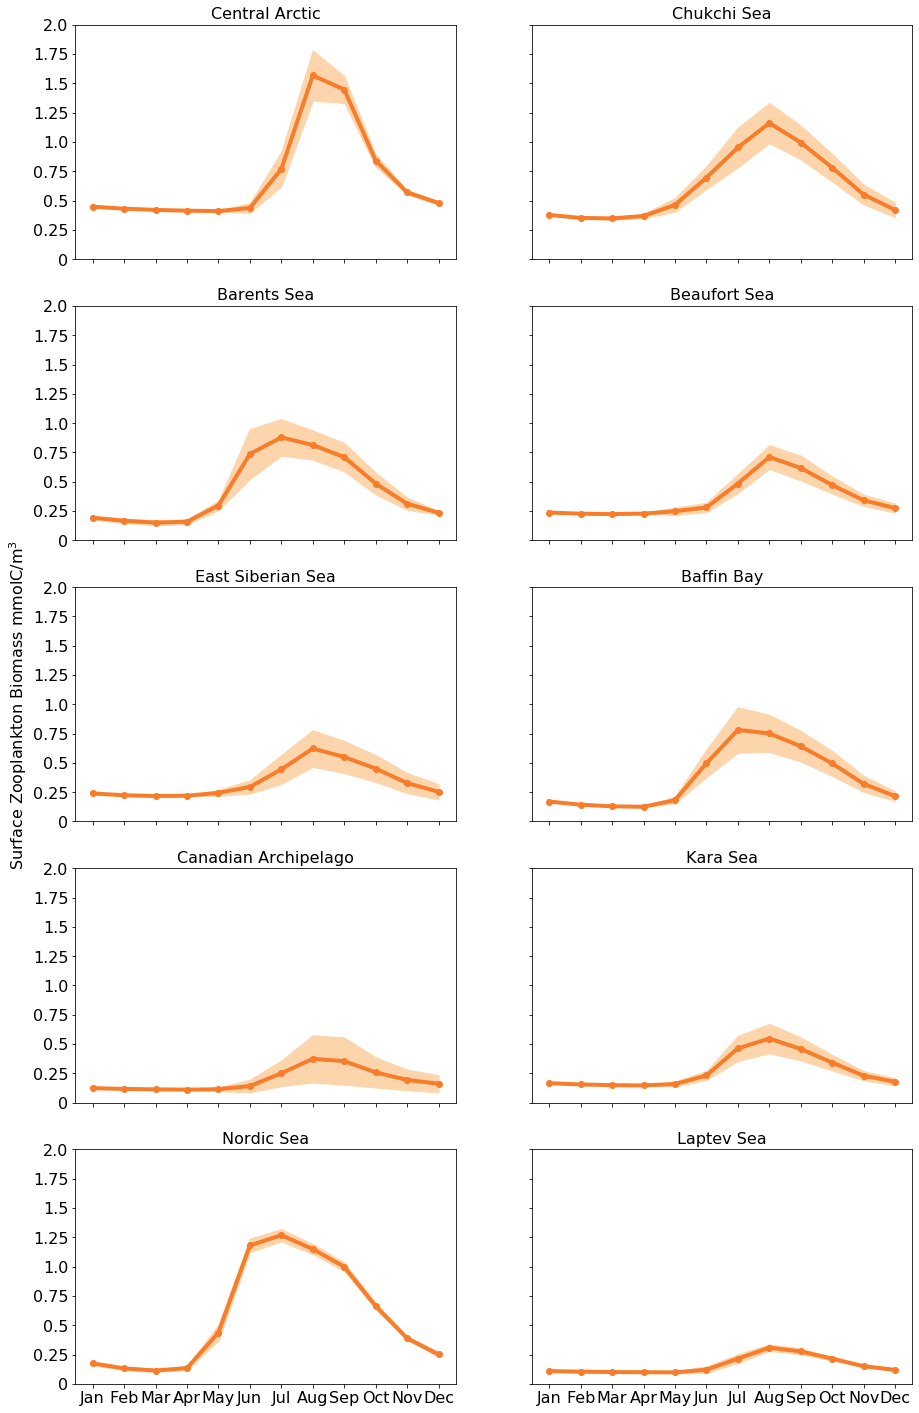

In [45]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(zooC_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(zooC_ao,axis=0)-err_ao,np.nanmean(zooC_ao,axis=0)+err_ao, color=cmap(2))
#ax1.set_ylabel('Surface Zooplankton Biomass $mmol C$/$m^3$', fontsize=16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0],fontsize=16)
ax1.set_ylim(0,2);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(zooC_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(zooC_bts,axis=0)-err_bts,np.nanmean(zooC_bts,axis=0)+err_bts, color=cmap(2))
#ax2.set_ylabel('Surface Zooplankton Biomass $mmol C$/$m^3$', fontsize=16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0],fontsize=16)
ax2.set_ylim(0,2);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(zooC_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(zooC_cs,axis=0)-err_cs,np.nanmean(zooC_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,2);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(zooC_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(zooC_ess,axis=0)-err_ess,np.nanmean(zooC_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Surface Zooplankton Biomass $mmol C$/$m^3$', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0],fontsize=16)
ax4.set_ylim(0,2);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(zooC_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(zooC_ca,axis=0)-err_ca,np.nanmean(zooC_ca,axis=0)+err_ca, color=cmap(2))
#ax5.set_ylabel('Surface Zooplankton Biomass $mmol C$/$m^3$', fontsize=16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0],fontsize=16)
ax5.set_ylim(0,2); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(zooC_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(zooC_ns,axis=0)-err_ns,np.nanmean(zooC_ns,axis=0)+err_ns, color=cmap(2))
#ax6.set_ylabel('Surface Zooplankton Biomass $mmol C$/$m^3$', fontsize=16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0],fontsize=16)
ax6.set_ylim(0,2);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(zooC_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(zooC_bs,axis=0)-err_bs,np.nanmean(zooC_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,2);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(zooC_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(zooC_bb,axis=0)-err_bb,np.nanmean(zooC_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,2);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(zooC_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(zooC_ks,axis=0)-err_ks,np.nanmean(zooC_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,2);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(zooC_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(zooC_ls,axis=0)-err_ls,np.nanmean(zooC_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,2);  ax.set_yticklabels(''); 
#cbar.set_label('Surface Zooplankton Biomass (mmol/m$^3$)', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/zooC_interannual_climatology',dpi=600, bbox_inches='tight')

In [46]:
# This is the error on the observations
err_ao = np.nanstd(chl_ao,axis=0)
err_cs = np.nanstd(chl_cs,axis=0)
err_bs = np.nanstd(chl_bs,axis=0)
err_ca = np.nanstd(chl_ca,axis=0)
err_bb = np.nanstd(chl_bb,axis=0)
err_ess = np.nanstd(chl_ess,axis=0)
err_ls = np.nanstd(chl_ls,axis=0)
err_ns = np.nanstd(chl_ns,axis=0)
err_bts = np.nanstd(chl_bts,axis=0)
err_ks = np.nanstd(chl_ks,axis=0)

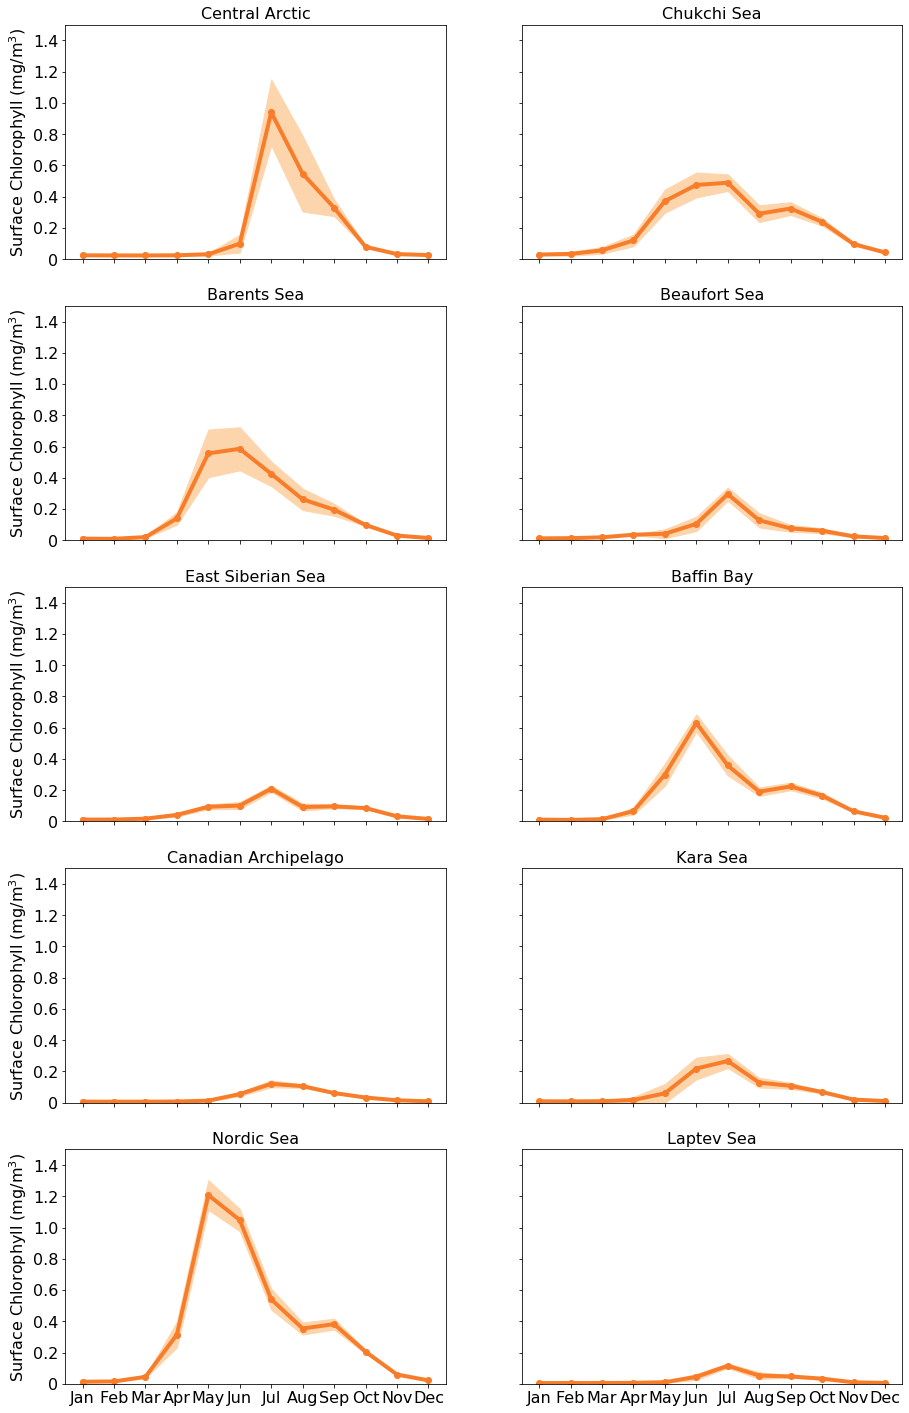

In [47]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(chl_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(chl_ao,axis=0)-err_ao,np.nanmean(chl_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_ylabel('Surface Chlorophyll (mg/m$^3$)', fontsize=16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],fontsize=16)
ax1.set_ylim(0,1.5);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(chl_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(chl_bts,axis=0)-err_bts,np.nanmean(chl_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_ylabel('Surface Chlorophyll (mg/m$^3$)', fontsize=16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],fontsize=16)
ax2.set_ylim(0,1.5);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(chl_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(chl_cs,axis=0)-err_cs,np.nanmean(chl_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,1.5);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(chl_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(chl_ess,axis=0)-err_ess,np.nanmean(chl_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Surface Chlorophyll (mg/m$^3$)', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],fontsize=16)
ax4.set_ylim(0,1.5);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(chl_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(chl_ca,axis=0)-err_ca,np.nanmean(chl_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_ylabel('Surface Chlorophyll (mg/m$^3$)', fontsize=16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],fontsize=16)
ax5.set_ylim(0,1.5); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(chl_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(chl_ns,axis=0)-err_ns,np.nanmean(chl_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_ylabel('Surface Chlorophyll (mg/m$^3$)', fontsize=16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],fontsize=16)
ax6.set_ylim(0,1.5);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(chl_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(chl_bs,axis=0)-err_bs,np.nanmean(chl_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,1.5);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(chl_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(chl_bb,axis=0)-err_bb,np.nanmean(chl_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,1.5);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(chl_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(chl_ks,axis=0)-err_ks,np.nanmean(chl_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,1.5);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(chl_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(chl_ls,axis=0)-err_ls,np.nanmean(chl_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,1.5);  ax.set_yticklabels(''); 
#cbar.set_label('Surface Chlorophyll (mg/m$^3$)', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/Chl_interannual_climatology',dpi=600, bbox_inches='tight')

In [48]:
# This is the error on the observations
err_ao = np.nanstd(ECOSYS_IFRAC_ao,axis=0)
err_cs = np.nanstd(ECOSYS_IFRAC_cs,axis=0)
err_bs = np.nanstd(ECOSYS_IFRAC_bs,axis=0)
err_ca = np.nanstd(ECOSYS_IFRAC_ca,axis=0)
err_bb = np.nanstd(ECOSYS_IFRAC_bb,axis=0)
err_ess = np.nanstd(ECOSYS_IFRAC_ess,axis=0)
err_ls = np.nanstd(ECOSYS_IFRAC_ls,axis=0)
err_ns = np.nanstd(ECOSYS_IFRAC_ns,axis=0)
err_bts = np.nanstd(ECOSYS_IFRAC_bts,axis=0)
err_ks = np.nanstd(ECOSYS_IFRAC_ks,axis=0)

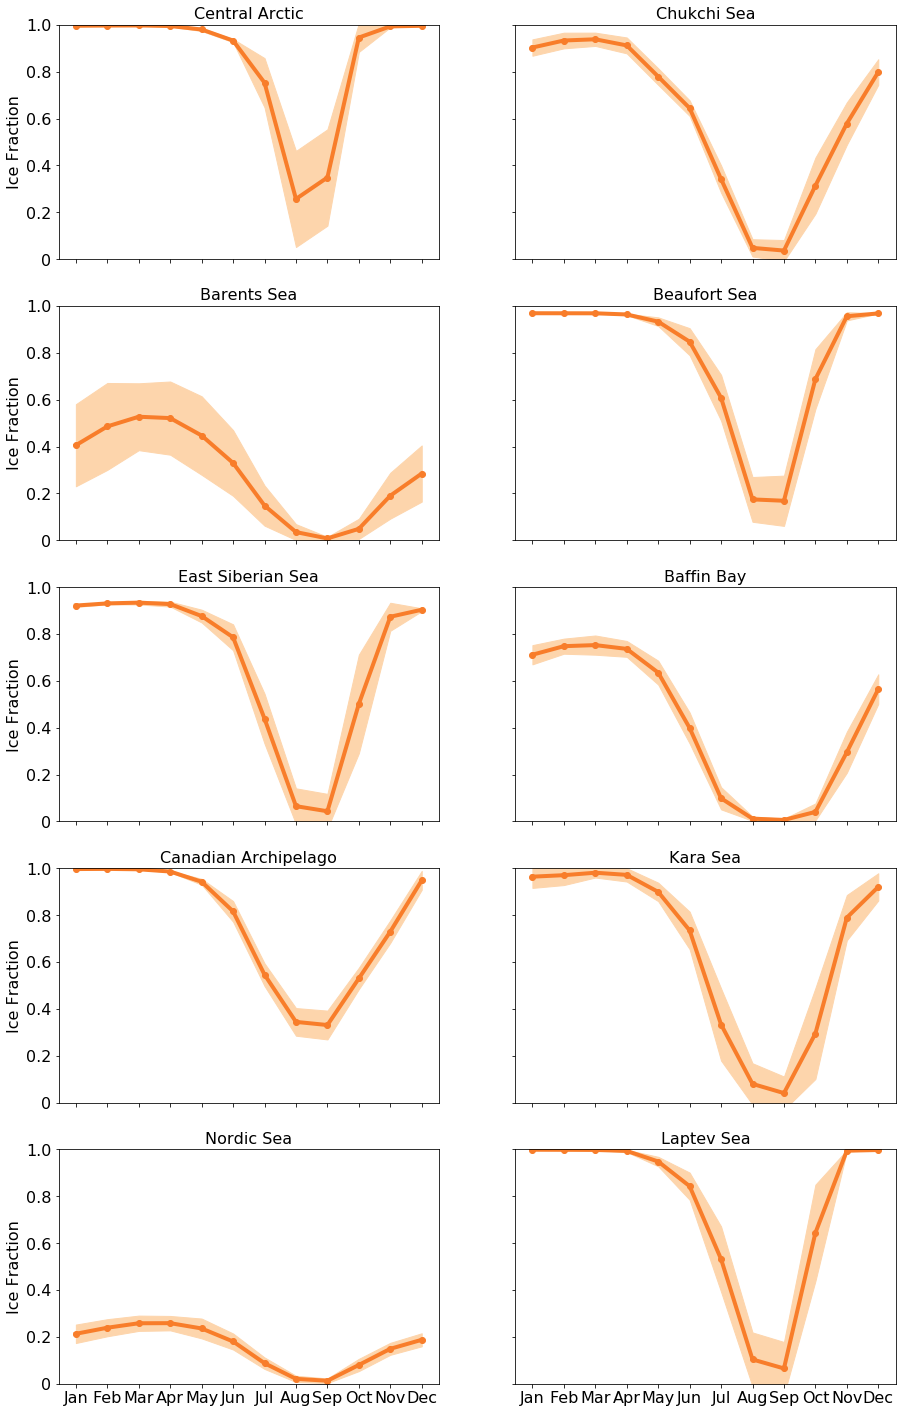

In [49]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(ECOSYS_IFRAC_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(ECOSYS_IFRAC_ao,axis=0)-err_ao,np.nanmean(ECOSYS_IFRAC_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_ylabel('Ice Fraction', fontsize=16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax1.set_ylim(0,1);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(ECOSYS_IFRAC_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(ECOSYS_IFRAC_bts,axis=0)-err_bts,np.nanmean(ECOSYS_IFRAC_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_ylabel('Ice Fraction', fontsize=16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax2.set_ylim(0,1);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(ECOSYS_IFRAC_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(ECOSYS_IFRAC_cs,axis=0)-err_cs,np.nanmean(ECOSYS_IFRAC_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(0,1);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(ECOSYS_IFRAC_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(ECOSYS_IFRAC_ess,axis=0)-err_ess,np.nanmean(ECOSYS_IFRAC_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Ice Fraction', fontsize=16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax4.set_ylim(0,1);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(ECOSYS_IFRAC_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(ECOSYS_IFRAC_ca,axis=0)-err_ca,np.nanmean(ECOSYS_IFRAC_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_ylabel('Ice Fraction', fontsize=16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax5.set_ylim(0,1); 
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(ECOSYS_IFRAC_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(ECOSYS_IFRAC_ns,axis=0)-err_ns,np.nanmean(ECOSYS_IFRAC_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_ylabel('Ice Fraction', fontsize=16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=16)
ax6.set_ylim(0,1);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(ECOSYS_IFRAC_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(ECOSYS_IFRAC_bs,axis=0)-err_bs,np.nanmean(ECOSYS_IFRAC_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(0,1);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(ECOSYS_IFRAC_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(ECOSYS_IFRAC_bb,axis=0)-err_bb,np.nanmean(ECOSYS_IFRAC_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(0,1);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(ECOSYS_IFRAC_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(ECOSYS_IFRAC_ks,axis=0)-err_ks,np.nanmean(ECOSYS_IFRAC_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(0,1);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(ECOSYS_IFRAC_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(ECOSYS_IFRAC_ls,axis=0)-err_ls,np.nanmean(ECOSYS_IFRAC_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(0,1);  ax.set_yticklabels(''); 
#cbar.set_label('Ice Fraction ', fontsize =16)
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/ICE_interannual_climatology',dpi=600, bbox_inches='tight')

In [50]:
# This is the error on the observations
err_ao = np.nanstd(temp_ao,axis=0)
err_cs = np.nanstd(temp_cs,axis=0)
err_bs = np.nanstd(temp_bs,axis=0)
err_ca = np.nanstd(temp_ca,axis=0)
err_bb = np.nanstd(temp_bb,axis=0)
err_ess = np.nanstd(temp_ess,axis=0)
err_ls = np.nanstd(temp_ls,axis=0)
err_ns = np.nanstd(temp_ns,axis=0)
err_bts = np.nanstd(temp_bts,axis=0)
err_ks = np.nanstd(temp_ks,axis=0)

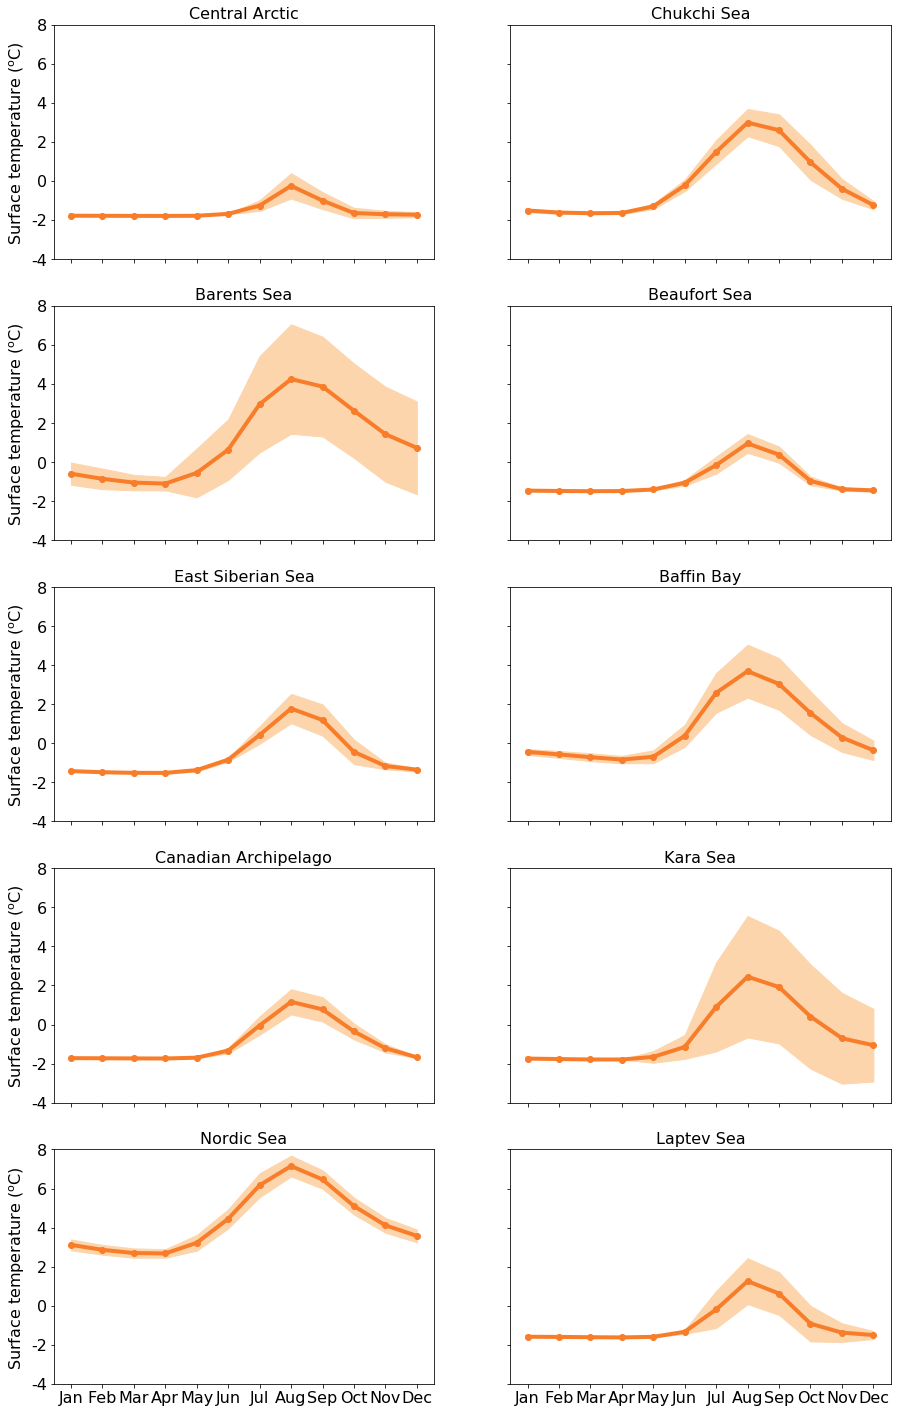

In [51]:
from matplotlib.gridspec import GridSpec
import matplotlib
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
cmap=matplotlib.cm.get_cmap('Oranges', 10)
cmap1=matplotlib.cm.get_cmap('Greens', 10)

#fig, ax = plt.subplots(figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(15, 25))
gs = GridSpec(nrows=5, ncols=2)

#subplot 1
ax1 = fig.add_subplot(gs[0, 0]);
lns1 = ax1.plot(months,np.nanmean(temp_ao,axis=0), '-o', color=cmap(5),linewidth=4,label='SeaWiFS')
ax1.fill_between(months, np.nanmean(temp_ao,axis=0)-err_ao,np.nanmean(temp_ao,axis=0)+err_ao, color=cmap(2))
ax1.set_ylabel('Surface temperature ($^o$C) ', fontsize =16)
ax1.set_title('Central Arctic', fontsize=16); ax1.set_yticklabels([-4,-2,0,2,4,6,8],fontsize=16)
ax1.set_ylim(-4,8);
ax1.set_xticklabels('')

ax2 = fig.add_subplot(gs[1, 0]);
lns1 = ax2.plot(months,np.nanmean(temp_bts,axis=0), '-o', color=cmap(5),linewidth=4)
ax2.fill_between(months, np.nanmean(temp_bts,axis=0)-err_bts,np.nanmean(temp_bts,axis=0)+err_bts, color=cmap(2))
ax2.set_ylabel('Surface temperature ($^o$C) ', fontsize =16)
ax2.set_title('Barents Sea', fontsize=16); ax2.set_yticklabels([-4,-2,0,2,4,6,8],fontsize=16)
ax2.set_ylim(-4,8);
ax2.set_xticklabels('')

ax3 = fig.add_subplot(gs[0, 1]);
lns1 = ax3.plot(months,np.nanmean(temp_cs,axis=0), '-o', color=cmap(5),linewidth=4)
ax3.fill_between(months, np.nanmean(temp_cs,axis=0)-err_cs,np.nanmean(temp_cs,axis=0)+err_cs, color=cmap(2))
ax3.set_title('Chukchi Sea', fontsize=16)
ax3.set_ylim(-4,8);  ax3.set_yticklabels('');
ax3.set_xticklabels('')

ax4 = fig.add_subplot(gs[2, 0]);
lns1 = ax4.plot(months,np.nanmean(temp_ess,axis=0), '-o', color=cmap(5),linewidth=4)
ax4.fill_between(months, np.nanmean(temp_ess,axis=0)-err_ess,np.nanmean(temp_ess,axis=0)+err_ess, color=cmap(2))
ax4.set_ylabel('Surface temperature ($^o$C) ', fontsize =16)
ax4.set_title('East Siberian Sea', fontsize=16); ax4.set_yticklabels([-4,-2,0,2,4,6,8],fontsize=16)
ax4.set_ylim(-4,8);
ax4.set_xticklabels('')

ax5 = fig.add_subplot(gs[3, 0])
lns1 = ax5.plot(months,np.nanmean(temp_ca,axis=0), '-o', color=cmap(5),linewidth=4)
ax5.fill_between(months, np.nanmean(temp_ca,axis=0)-err_ca,np.nanmean(temp_ca,axis=0)+err_ca, color=cmap(2))
ax5.set_ylabel('Surface temperature ($^o$C) ', fontsize =16)
ax5.set_title('Canadian Archipelago', fontsize=16); ax5.set_yticklabels([-4,-2,0,2,4,6,8],fontsize=16)
ax5.set_ylim(-4,8);
ax5.set_xticklabels('')

ax6 = fig.add_subplot(gs[4, 0]);
lns1 = ax6.plot(months,np.nanmean(temp_ns,axis=0), '-o', color=cmap(5),linewidth=4)
ax6.fill_between(months, np.nanmean(temp_ns,axis=0)-err_ns,np.nanmean(temp_ns,axis=0)+err_ns, color=cmap(2))
ax6.set_ylabel('Surface temperature ($^o$C) ', fontsize =16)
ax6.set_title('Nordic Sea', fontsize=16); ax6.set_yticklabels([-4,-2,0,2,4,6,8],fontsize=16)
ax6.set_ylim(-4,8);
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)

ax7 = fig.add_subplot(gs[1, 1]);
lns1 = ax7.plot(months,np.nanmean(temp_bs,axis=0), '-o', color=cmap(5),linewidth=4)
ax7.fill_between(months, np.nanmean(temp_bs,axis=0)-err_bs,np.nanmean(temp_bs,axis=0)+err_bs, color=cmap(2))
ax7.set_title('Beaufort Sea', fontsize=16)
ax7.set_xticklabels('');  ax7.set_yticklabels('')
ax7.set_ylim(-4,8);

ax8 = fig.add_subplot(gs[2, 1]);
lns1 = ax8.plot(months,np.nanmean(temp_bb,axis=0), '-o', color=cmap(5),linewidth=4)
ax8.fill_between(months, np.nanmean(temp_bb,axis=0)-err_bb,np.nanmean(temp_bb,axis=0)+err_bb, color=cmap(2))
ax8.set_title('Baffin Bay', fontsize=16)
ax8.set_xticklabels('');  ax8.set_yticklabels('')
ax8.set_ylim(-4,8);

ax9 = fig.add_subplot(gs[3, 1]);
lns1 = ax9.plot(months,np.nanmean(temp_ks,axis=0), '-o', color=cmap(5),linewidth=4)
ax9.fill_between(months, np.nanmean(temp_ks,axis=0)-err_ks,np.nanmean(temp_ks,axis=0)+err_ks, color=cmap(2))
ax9.set_title('Kara Sea', fontsize=16)
ax9.set_xticklabels(''); ax9.set_yticklabels(''); 
ax9.set_ylim(-4,8);

ax = fig.add_subplot(gs[4,1]);
lns1 = ax.plot(months,np.nanmean(temp_ls,axis=0), '-o', color=cmap(5),linewidth=4)
ax.fill_between(months, np.nanmean(temp_ls,axis=0)-err_ls,np.nanmean(temp_ls,axis=0)+err_ls, color=cmap(2))
ax.set_title('Laptev Sea', fontsize=16)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=16)
ax.set_ylim(-4,8);  ax.set_yticklabels(''); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/temperature_interannual_climatology',dpi=600, bbox_inches='tight')